In [3]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 26.4 MB/s eta 0:00:00


In [4]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

In [5]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

In [6]:
# Modelado y Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.plot import plot_prediction_intervals
import shap
import math

In [8]:
from google.colab import files

uploaded = files.upload()

Saving 007_ZW Parque Pizamos.csv to 007_ZW Parque Pizamos.csv


In [9]:
import io

#df = pd.read_csv(io.BytesIO(uploaded['001_ZW Parque Ingenio-1AP.csv']))
df = pd.read_csv(io.BytesIO(uploaded['007_ZW Parque Pizamos.csv']), decimal=",")
print(df)

    FECHA.CONEXION  DIA_SEMANA  LABORAL  FIN_DE_SEMANA  FESTIVO  \
0       2024-12-19           3        1              0        0   
1       2024-12-20           4        1              0        0   
2       2024-12-21           5        0              1        0   
3       2024-12-22           6        0              1        0   
4       2024-12-23           0        1              0        0   
..             ...         ...      ...            ...      ...   
98      2025-03-27           3        1              0        0   
99      2025-03-28           4        1              0        0   
100     2025-03-29           5        0              1        0   
101     2025-03-30           6        0              1        0   
102     2025-03-31           0        1              0        0   

     PORCENTAJE.USO  NUMERO.CONEXIONES  USAGE.KB  
0              3.46                 10     98283  
1             33.20                 26   1005929  
2              0.80                 16    

In [10]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.18.0
Versión scikit-learn: 1.6.1
Versión pandas: 2.2.2
Versión numpy: 2.0.2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
# Preparación del dato
# ==============================================================================
df['FECHA.CONEXION'] = pd.to_datetime(df['FECHA.CONEXION'], format='%Y-%m-%d')
df = df.set_index('FECHA.CONEXION')
df = df.asfreq('D') # Month Start (04-01; 05-01; 06-01...)
df

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-12-19,3,1,0,0,3.46,10,98283
2024-12-20,4,1,0,0,33.20,26,1005929
2024-12-21,5,0,1,0,0.80,16,20729
2024-12-22,6,0,1,0,4.49,21,143931
2024-12-23,0,1,0,0,84.20,23,2111377
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,68.00,34,2458519
2025-03-28,4,1,0,0,88.00,26,2115047
2025-03-29,5,0,1,0,142.00,55,4540925


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [12]:
df = df.sort_index() # En caso de que esten las fechas desorganizadas se organizan de forma ascendente
df

,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-12-19,3,1,0,0,3.46,10,98283
2024-12-20,4,1,0,0,33.20,26,1005929
2024-12-21,5,0,1,0,0.80,16,20729
2024-12-22,6,0,1,0,4.49,21,143931
2024-12-23,0,1,0,0,84.20,23,2111377
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,68.00,34,2458519
2025-03-28,4,1,0,0,88.00,26,2115047
2025-03-29,5,0,1,0,142.00,55,4540925


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
#df["USAGE_LOG"] = np.log1p(df["USAGE.KB"])
#df["PORCENTAJE_LOG"] = np.log1p(df["PORCENTAJE.USO"])
#df["CONEXIONES_LOG"] = np.log1p(df["NUMERO.CONEXIONES"])

In [13]:
df

,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-12-19,3,1,0,0,3.46,10,98283
2024-12-20,4,1,0,0,33.20,26,1005929
2024-12-21,5,0,1,0,0.80,16,20729
2024-12-22,6,0,1,0,4.49,21,143931
2024-12-23,0,1,0,0,84.20,23,2111377
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,68.00,34,2458519
2025-03-28,4,1,0,0,88.00,26,2115047
2025-03-29,5,0,1,0,142.00,55,4540925


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


En caso de que se tenga que convertir la columna PORCENTAJE.USO:

In [14]:
df.dtypes

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,0
DIA_SEMANA,int64
LABORAL,int64
FIN_DE_SEMANA,int64
FESTIVO,int64
PORCENTAJE.USO,float64
NUMERO.CONEXIONES,int64
USAGE.KB,int64


In [15]:
#df['NUMERO.CONEXIONES'].str.replace(',', '.', regex=True)

In [16]:
print(f'Número de filas con missing values: {df.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [17]:
rows_with_na = df[df.isna().any(axis=1)]
print("\nRows with any NA values:")
print(rows_with_na)


Rows with any NA values:
Empty DataFrame
Columns: [DIA_SEMANA, LABORAL, FIN_DE_SEMANA, FESTIVO, PORCENTAJE.USO, NUMERO.CONEXIONES, USAGE.KB]
Index: []


In [18]:
rows, columns = df.shape
rows

103

Steps, el número en que se va a separar el datset en train y test

In [19]:
steps = rows*0.2
steps = math.floor(steps)
steps

20

In [20]:
# Separación datos train-test
# ==============================================================================
df_train = df[:-steps]
df_test  = df[-steps:]
print(f"Fechas train : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Fechas test  : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Fechas train : 2024-12-19 00:00:00 --- 2025-03-11 00:00:00  (n=83)
Fechas test  : 2025-03-12 00:00:00 --- 2025-03-31 00:00:00  (n=20)


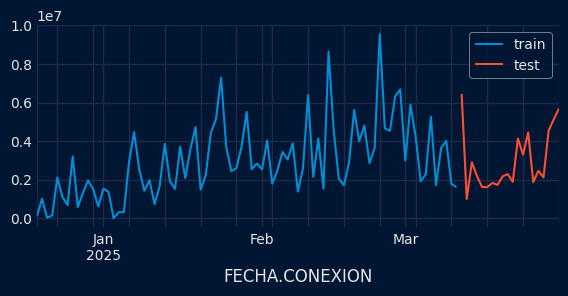

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [21]:
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
ax.legend();

In [22]:
exog_variables = ['DIA_SEMANA', 'LABORAL', 'FIN_DE_SEMANA', 'FESTIVO', 'PORCENTAJE.USO', 'NUMERO.CONEXIONES']
#exog_variables = ['PORCENTAJE.USO', 'NUMERO.CONEXIONES']

In [23]:
# Create and train forecaster WITH exogenous variables
# Keep using ForecasterRecursive as in your original code
forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=123),
    lags=6
)
# Ajuste con variables exogenas
forecaster.fit(
    y=df_train['USAGE.KB'],
    exog=df_train[exog_variables]  # Add exogenous variables here
)

# Ajuste sin variables exogenas
#forecaster.fit(
#    y=df_train['USAGE.KB']
#)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
# Predicciones con variables exogenas futuras
predictions = forecaster.predict(
    steps=steps,
    exog=df_test[exog_variables]  # Future values of exogenous variables
)

# Predicciones sin variables exogenas futuras
#predictions = forecaster.predict(
#    steps=steps
#)
#predictions.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


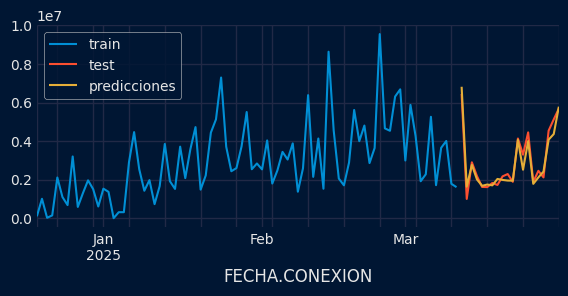

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predicciones')
ax.legend();

In [26]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['USAGE.KB'],
                y_pred = predictions
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 136139945466.47429


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [27]:
#print(predictions,df_test['USAGE.KB'])
usage_kb_compared = pd.DataFrame({
    'USAGE.KB_predicho': predictions,
    'USAGE.KB_real': df_test['USAGE.KB']
})
difference = predictions - df_test['USAGE.KB']
usage_kb_compared['error_absoluto'] = difference.abs()
usage_kb_compared['error_relativo'] = usage_kb_compared['error_absoluto'] / usage_kb_compared['USAGE.KB_real']
print(usage_kb_compared)

            USAGE.KB_predicho  USAGE.KB_real  error_absoluto  error_relativo
2025-03-12         6819119.45        6446268       372851.45        0.057840
2025-03-13         1634299.20         998556       635743.20        0.636663
2025-03-14         2765819.60        2899542       133722.40        0.046118
2025-03-15         2009244.08        2179843       170598.92        0.078262
2025-03-16         1679393.98        1620628        58765.98        0.036261
2025-03-17         1745582.15        1611845       133737.15        0.082971
2025-03-18         1703921.38        1826513       122591.62        0.067118
2025-03-19         2035469.12        1722662       312807.12        0.181584
2025-03-20         1985626.16        2168643       183016.84        0.084392
2025-03-21         1952040.85        2290797       338756.15        0.147877
2025-03-22         1946965.69        1887724        59241.69        0.031383
2025-03-23         4062501.61        4134785        72283.39        0.017482

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
predictions_normal = np.expm1(predictions)
predictions_normal.head()

,pred
2024-12-31,1.567828e+06
2025-01-01,7.842455e+05
2025-01-02,1.711120e+06
2025-01-03,5.797501e+06
2025-01-04,2.153644e+06


In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['USAGE.KB'],
                y_pred = predictions_normal
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 17463539780757.912


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


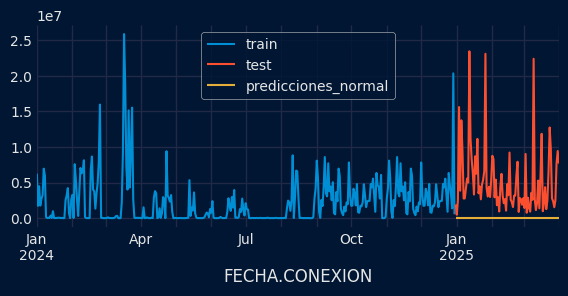

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Gráfico de predicciones normales (sin logaritmo) vs valores reales (sin logaritmo)
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predicciones_normal')
ax.legend();

In [ ]:
# hyperparameters search: grid search with exogenous variables
forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# train and validation partitions
cv = TimeSeriesFold(
      steps              = 91,
      initial_train_size = int(len(df_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,
    )

# candidate values of lags
lags_grid = [10, 20]

# Candidate values of hyperparameters of the regressor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = df_train['USAGE_LOG'],
                        exog        = df_train[['PORCENTAJE_LOG', 'CONEXIONES_LOG']],  # ADDED: Include exogenous variables
                        cv          = cv,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        metric      = 'mean_squared_error',
                        return_best = True,
                        n_jobs      = 'auto',
                        verbose     = False
                  )

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.874542426349119


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Resultados de la búsqueda de hiperparámetros
# ==============================================================================
resultados_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.874542,3,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.885926,3,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.892568,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.907353,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.908474,3,250
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 250}",0.909963,5,250
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.910173,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 250}",0.921170,5,250
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 250}",0.930477,10,250
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 250}",0.930835,10,250


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
